In [1]:
!pip install pytorch-tabnet
!git clone https://github.com/alezakuskin/Stark_ML
!cd /usr/local/lib/python3.7/dist-packages/pytorch_tabnet && patch </content/Stark_ML/float64.patch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'Stark_ML'...
remote: Enumerating objects: 866, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 866 (delta 86), reused 89 (delta 56), pack-reused 737
Receiving objects: 100% (866/866), 33.05 MiB | 11.52 MiB/s, done.
Resolving deltas: 100% (510/510), done.
patching file abstract_model.py
patching file multitask.py
patching file pretraining.py
patching file tab_model.py
patching file tab_network.py
patching file utils.py


In [2]:
import os

!pip install optuna
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch
import importlib

torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn import svm
from google.colab import output

from pytorch_tabnet.tab_model import  TabNetRegressor
np.random.seed(777)

output.clear()

In [3]:
if os.path.isdir('Stark_ML'):
    !rm -rf Stark_ML

#!!!
#!!!
#!!!
#Don't gorget to change branch
!git clone -b Temperature-tuning https://github.com/alezakuskin/Stark_ML

import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet


importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)


from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
output.clear()

In [4]:
FIG_SMALL = (3.375, 3.375)
FIG_LARGE = (6.75, 3.375)

In [5]:
data = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BC'
                   )

# Figure 1. Width histogram

In [6]:
elements_to_exclude = ['S', 'Mg', 'Mn']
data_width = data[np.isnan(data['w (A)']) == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)
data_test_q4, target_test_q4 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 75,
                                              random_state = 6)

d1 = pd.concat([target_width[target_width <= target_width.describe()['25%']].reset_index(),
                pd.Series(np.full(shape=len(target_width[target_width <= target_width.describe()['25%']]), fill_value='Train'))],
               axis = 1,
               ignore_index = True
               ).rename(columns = {1 : 'w', 2 : 'Type'})
d2 = pd.concat([target_test_q1.reset_index(),
                pd.Series(np.full(shape=len(target_test_q1), fill_value='Test'))],
               axis = 1,
               ignore_index = True
               ).rename(columns = {1 : 'w', 2 : 'Type'})
q1 = pd.concat([d1, d2], axis = 0, ignore_index=True)

d1 = pd.concat([target_width[target_width > target_width.describe()['75%']].reset_index(),
                pd.Series(np.full(shape=len(target_width[target_width > target_width.describe()['75%']]), fill_value='Train'))],
               axis = 1,
               ignore_index = True
               ).rename(columns = {1 : 'w', 2 : 'Type'})
d2 = pd.concat([target_test_q4.reset_index(),
                pd.Series(np.full(shape=len(target_test_q4), fill_value='Test'))],
               axis = 1,
               ignore_index = True
               ).rename(columns = {1 : 'w', 2 : 'Type'})
q4 = pd.concat([d1, d2], axis = 0, ignore_index=True)

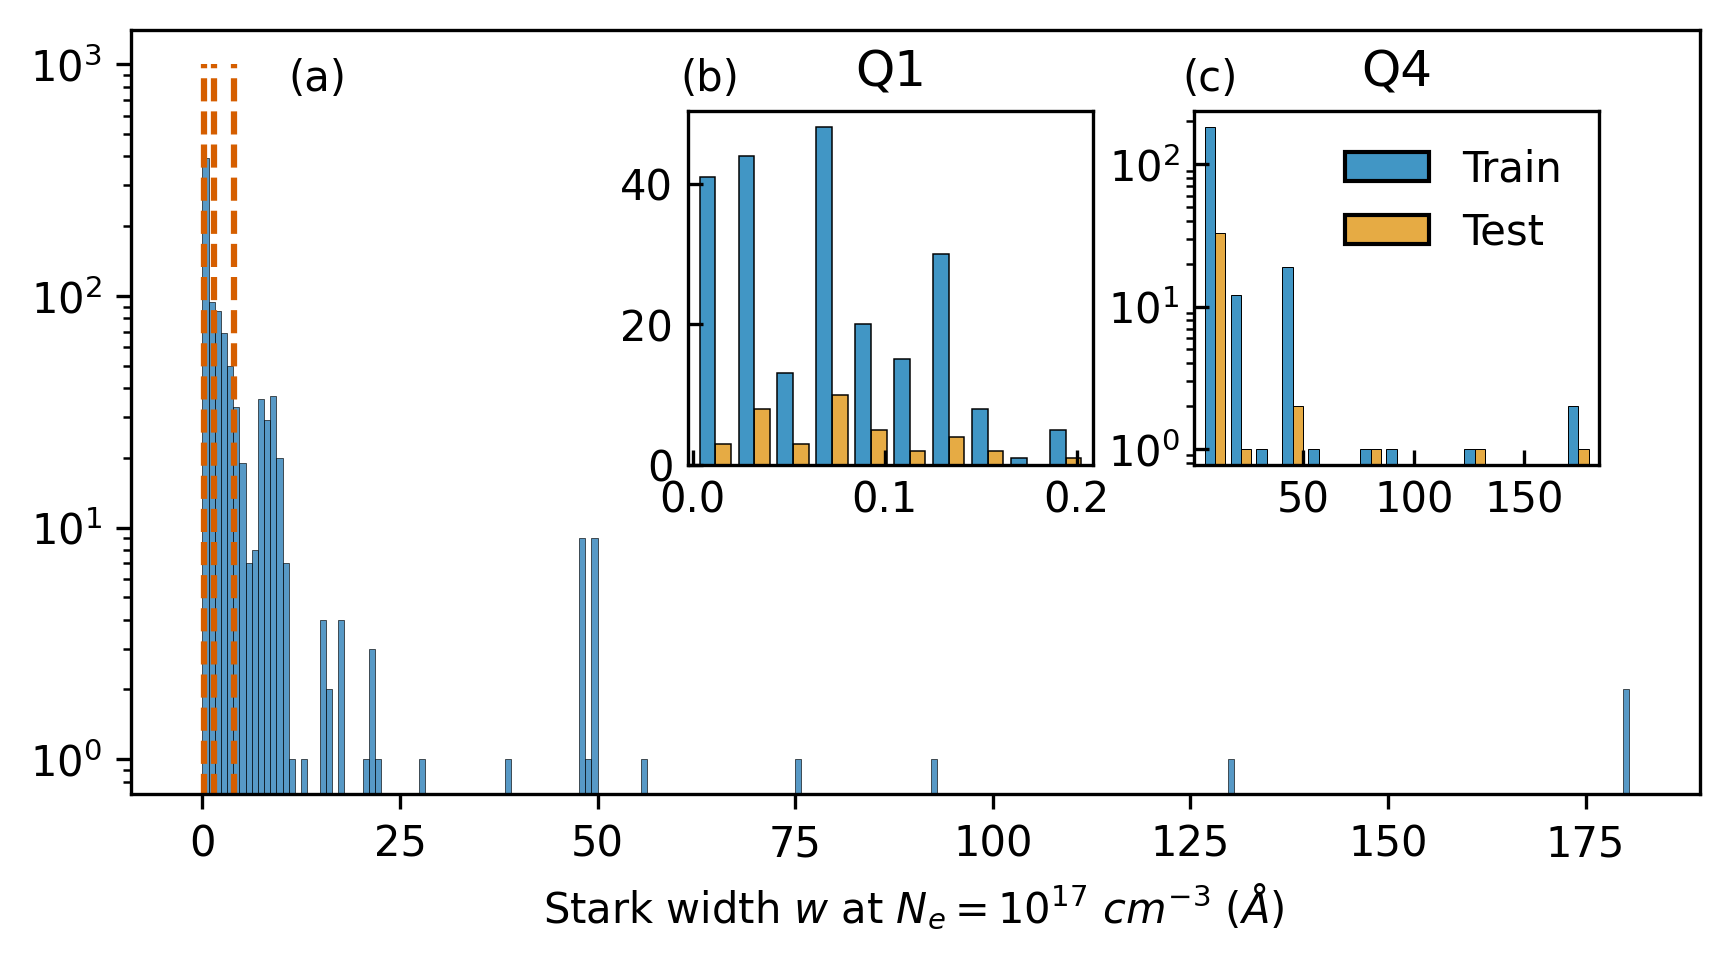

In [21]:
sns.color_palette('gray')

fig, ax = plt.subplots(figsize = FIG_LARGE, dpi = 300)
#n, bins, patches = plt.hist(data['w (A)'], bins='auto', log=True, rwidth = 0.8)
sns.histplot(data = data, x = data['w (A)'], ax = ax, log_scale = (False, True), palette = 'colorblind')
ax.vlines(x = data['w (A)'].describe()['25%'], ymin = 0, ymax = 1000, ls='--', colors='#d55e00')
ax.vlines(x = data['w (A)'].describe()['50%'], ymin = 0, ymax = 1000, ls='--', colors='#d55e00')
ax.vlines(x = data['w (A)'].describe()['75%'], ymin = 0, ymax = 1000, ls='--', colors='#d55e00')

ax.set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ')
ax.set_ylabel(None)

ax_in1 = fig.add_axes([0.4, 0.45, 0.20, 0.35])
#ax_in1.axes.yaxis.set_ticklabels([])
ax_in2 = fig.add_axes([0.65, 0.45, 0.20, 0.35])
#ax_in2.axes.yaxis.set_ticklabels([])

ax_in1.set_title('Q1')
ax_in2.set_title('Q4')

sns.histplot(data = q1, x = 'w', hue = 'Type', multiple="dodge", shrink=.8, ax = ax_in1, palette = 'colorblind')
sns.histplot(data = q4, x = 'w', hue = 'Type', multiple="dodge", shrink=.8, ax = ax_in2, bins = 15, log_scale = (False, True), palette = 'colorblind')
ax_in2.get_legend().set_title(None)
ax_in2.get_legend().set_frame_on(False)
ax_in1.get_legend().remove()
ax_in1.set(ylabel = None)
ax_in2.set(ylabel = None)
ax_in1.set(xlabel = None)
ax_in2.set(xlabel = None)
ax_in1.tick_params('both', direction = 'in')
ax_in2.tick_params('both', direction = 'in')
ax_in1.set_xlim(target_width.describe()['min'] - 0.02 * (target_width.describe()['25%'] - target_width.describe()['min']),
                target_width.describe()['25%'] + 0.02 * (target_width.describe()['25%'] - target_width.describe()['min']))
ax_in2.set_xlim(target_width.describe()['75%'] - 0.02 * (target_width.describe()['max'] - target_width.describe()['75%']),
                target_width.describe()['max'] + 0.02 * (target_width.describe()['max'] - target_width.describe()['75%']))
ax.text(x = 0.1, y = 0.92, s = '(a)', transform = ax.transAxes)
ax.text(x = 0.35, y = 0.92, s = '(b)', transform = ax.transAxes)
ax.text(x = 0.67, y = 0.92, s = '(c)', transform = ax.transAxes)

plt.show()

fig.savefig('D:\\Laboratory\\Papers\\Physical Review Letters\\Paper 2022\\Figures\\Fig.1.Colorblind.svg', transparent = True, format = 'svg')

In [13]:
print(sns.color_palette('colorblind').as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


In [15]:
sns.color_palette('colorblind').as_hex()

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

# Figure 2. Elements pie chart

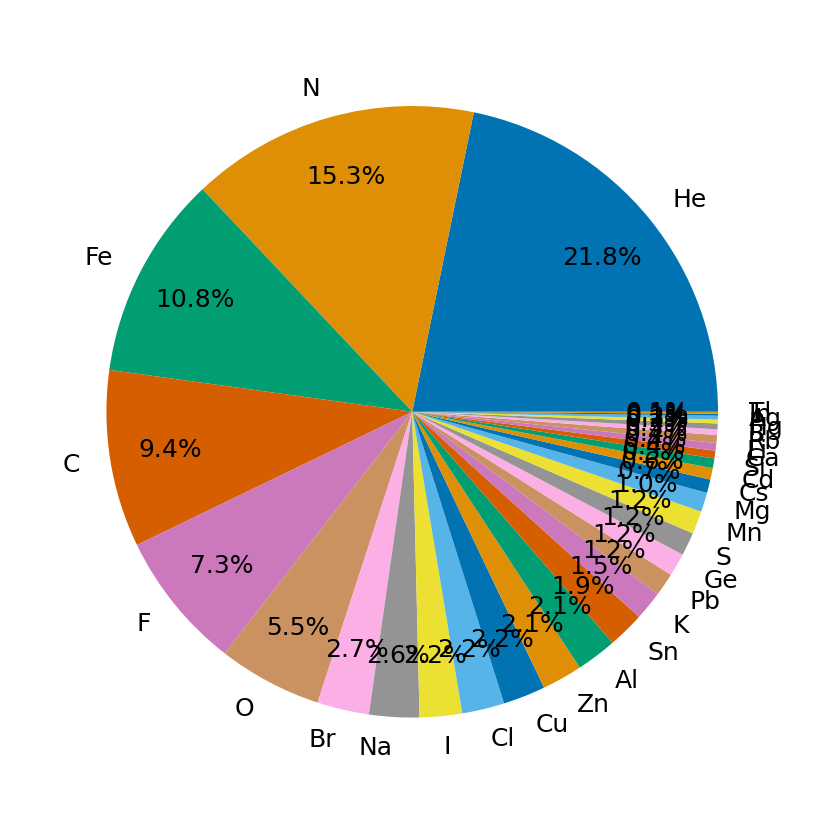

In [52]:
new_rc_params = {'text.usetex': False,
                "svg.fonttype": 'none'
                }
plt.rcParams.update(new_rc_params)


fig, ax = plt.subplots(figsize = FIG_SMALL, dpi = 300)

ax.pie(data['Element'].value_counts(), labels = data['Element'].value_counts().index, colors = sns.color_palette('colorblind'), autopct = '%.1f%%', labeldistance = 1.1, pctdistance = 0.8, textprops = {'size' : 6})

plt.show()

fig.savefig('Fig.2.Pie chart. Colorblind.svg', transparent = True, format = 'svg')

# Figure 3. 